In [1]:
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import soundfile as sf
from scipy.signal import butter, filtfilt

# 載入音訊檔案

In [2]:
# 指定存放 WAV 檔案的根目錄
wav_directory = "one_microphone"

def normalize_audio(wav):
    # 標準化音頻信號
    factor = np.max(np.abs(wav))
    if factor == 0:
        return wav
    return wav / factor

def loudness_normalize_audio(wav, target_dB=-20.0):
    # 計算信號的RMS
    rms = np.sqrt(np.mean(np.square(wav)))
    if rms == 0:
        return wav
    # 計算響度校正因子
    scalar = 10 ** (target_dB / 20) / rms
    return wav * scalar

def amplify_audio(wav, factor):
    # 放大音頻信號
    return wav * factor

def trim_audio(wav, sr, trim_duration=0.5):
    # 移除前後 trim_duration 秒
    trim_samples = int(trim_duration * sr)
    if len(wav) > 2 * trim_samples:
        return wav[trim_samples:-trim_samples]
    else:
        return wav  # 如果音頻長度不足以移除前後 trim_duration 秒，則不進行裁剪
    
def hamming_window(wav):
    # 應用漢明窗以減少邊緣效應
    return wav * np.hamming(len(wav))
    
    

def load_wav_files(directory, target_sr=16000, amplification_factor=80, trim_duration=1):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        with tqdm(total=len(files), desc='Loading files', unit='file') as pbar:
            for file in files:
                if file.endswith(".wav") and file != 'all_channel.wav':
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=None)
                    if sr != target_sr:
                        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                    
                    y = trim_audio(y, sr=target_sr)
                    y = normalize_audio(y)
                    y = loudness_normalize_audio(y)
                    y = amplify_audio(y, amplification_factor)
                    # remove wav_directory from root
                    path = root.split(os.path.sep)
                    filename = f'{path[1]}_{file}'
                    pbar.set_postfix(file=filename,)
                    wav_files.append((y, filename))
                pbar.update(1)
    return wav_files


def highpass_filter(wav_data, sr, cutoff=100, order=5):
    """
    Apply a high-pass filter to the audio signal to remove low-frequency noise like wind noise.

    :param wav_data: Audio time series and file name tuple
    :param sr: Sample rate
    :param cutoff: Cutoff frequency for the high-pass filter
    :param order: Order of the filter
    :return: Filtered audio time series
    """
    y, file_name = wav_data
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered, file_name



In [3]:
target_sample_rate = 22050
# 指定存放 WAV 檔案的根目錄
loaded_files = load_wav_files('one_microphone', target_sr=target_sample_rate, amplification_factor=80, trim_duration=1)


Loading files: 0file [00:00, ?file/s]
Loading files: 100%|██████████| 11/11 [00:03<00:00,  3.37file/s, file=normal-XX-10_XX-10-11.wav]


In [8]:
loaded_files += load_wav_files('soundcam_dataset', target_sr=target_sample_rate, amplification_factor=80, trim_duration=1)

Loading files: 0file [00:00, ?file/s]
Loading files: 100%|██████████| 113/113 [01:43<00:00,  1.09file/s, file=normal-34A-12-25-2_Mic111.wav]


In [87]:
from scipy.fftpack import fft
# 計算音頻信號的傅立葉變換
def frequency_domain_analysis(file, sr, save_only=False):
    y, name = file
    y = hamming_window(y)
    max_length = len(y) // sr
    for sec in tqdm(range(max_length), desc='Processing audio segments', unit='second'):
        start = sec * sr
        end = start + sr
        y_segment = y[start:end]
        
        N = len(y_segment)  # 信號長度
        T = 1.0 / sr  # 取樣間隔
        yf = fft(y_segment)
        xf = np.fft.fftfreq(N, T)[:N//2]
    
        # 繪製頻譜圖
        plt.figure(figsize=(8, 2))
        plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
        # plt.xlim(0, 1000)
        plt.title(f'Frequency Spectrum of Audio Signal {name} in second {sec}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.grid()
        if save_only:
            plt.savefig(f'frequency_domain/{name}_frequency_spectrum_{sec}.png')
            plt.close()
        else:
            plt.show()


frequency_domain_analysis(loaded_files[-400], target_sample_rate, save_only=True)


Processing audio segments: 100%|██████████| 29/29 [00:01<00:00, 14.51second/s]


# auto correlation

In [17]:
# 讀取音訊文件
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 計算標準化自相關性（每隔指定時間步長計算一次）
def auto_correlation(x, step_size):
    result = []
    for lag in range(0, len(x), step_size):
        if lag == 0:
            autocorr_value = signal.correlate(x[:step_size], x[:step_size], mode='valid')
        else: 
            next = lag + step_size
            if next >= len(x):
                break
            autocorr_value = signal.correlate(x[:step_size], x[lag: next], mode='valid')
    
        result.append(autocorr_value)
#     
    # 正規化自相關性
    norm_autocorr = np.array(result) / np.max(result)
    return norm_autocorr
    


In [35]:
y = loaded_files[-1][0]
# 設定最大滯後值為整段音訊的長度
max_lag = len(y)
# 設定步長，例如每 1.15 秒計算一次
step_size = target_sample_rate * 1
# 計算自相關性
corr = auto_correlation(y, step_size)
corr

array([[ 1.00000000e+00],
       [-5.25479764e-02],
       [-1.43177593e-02],
       [ 4.39248420e-03],
       [ 2.36661676e-02],
       [ 3.66221219e-02],
       [-8.16548690e-02],
       [-2.06579063e-02],
       [-1.34220105e-02],
       [-5.47011159e-02],
       [-1.15757480e-01],
       [-2.51147468e-02],
       [-4.53112051e-02],
       [-2.86929626e-02],
       [ 5.55517792e-04],
       [-8.47467184e-02],
       [-4.40382510e-02],
       [-2.49657761e-02],
       [-2.22718567e-02],
       [-9.32837054e-02],
       [ 1.82937592e-01],
       [-9.14103687e-02],
       [-1.13329245e-02],
       [ 1.46682322e-01],
       [ 1.07648503e-02],
       [ 1.24133248e-02],
       [-5.85073568e-02],
       [ 3.79628390e-02],
       [-3.61424498e-02]], dtype=float32)

In [36]:
# 繪製自相關性圖
def plot_corr(file, step_size, save_only=False):
    wav, name = file
    corr = auto_correlation(wav, step_size)
    lags = np.arange(0, len(corr))
    plt.figure(figsize=(10, 5))
    plt.stem(lags, corr, use_line_collection=True)
    plt.xlabel('Lag number')
    plt.ylabel('Normalized Auto-correlation')
    plt.title(f'Normalized Auto-correlation of {name}')
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.grid(True)
    if save_only:
        plt.savefig(f'sig_autocorrelation/{name}_autocorrelation.png')
        plt.close()
    else:
        plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_119580\3309265101.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, corr, use_line_collection=True)


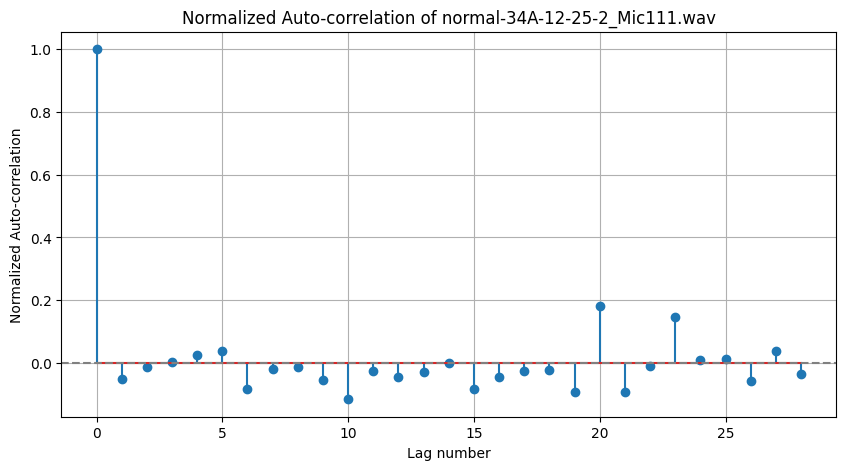

In [37]:
plot_corr(loaded_files[-1], step_size, save_only=False)

In [38]:
for idx, audio in enumerate(tqdm(loaded_files, desc='Processing audios', unit='audio')):
    plot_corr(audio, step_size, save_only=True)

Processing audios:   0%|          | 0/913 [00:00<?, ?audio/s]C:\Users\User\AppData\Local\Temp\ipykernel_119580\3309265101.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, corr, use_line_collection=True)
Processing audios:  32%|███▏      | 288/913 [00:27<01:00, 10.32audio/s]C:\Users\User\AppData\Local\Temp\ipykernel_119580\19108605.py:21: RuntimeWarning: invalid value encountered in divide
  norm_autocorr = np.array(result) / np.max(result)
Processing audios: 100%|██████████| 913/913 [01:25<00:00, 10.65audio/s]


In [43]:
# Compute local onset autocorrelation
y, name = loaded_files[0]
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=target_sample_rate, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=target_sample_rate,
                                      hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.feature.tempo(onset_envelope=oenv, sr=target_sample_rate,
                              hop_length=hop_length)[0]

AttributeError: module 'librosa.feature' has no attribute 'tempo'

In [41]:
def autocorrelation(signal, sr, hop_length=512):
    odf = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
    ac = librosa.autocorrelate(odf, max_size=1 * sr // hop_length)
    norm_ac = librosa.util.normalize(ac)
    return norm_ac

def plot_autocorrelation(file, sr, save_only=False):
    wav, name = file
    autocorr = autocorrelation(wav, sr)
    plt.plot(autocorr)
    plt.title('Autocorrelation of Wind Turbine Sound')
    plt.xlabel('Lag (samples)')
    plt.ylabel('Autocorrelation')
    if save_only:
        plt.savefig(f'autocorrelation_librosa/{name}_autocorrelation.png')
        plt.close()
    else:
        plt.show()


In [42]:
for idx, audio in enumerate(tqdm(loaded_files, desc='Processing audios', unit='audio')):
    plot_autocorrelation(audio, sr=target_sample_rate, save_only=True)

Processing audios: 100%|██████████| 913/913 [02:33<00:00,  5.96audio/s]


In [27]:
def convert_to_mean_spectrogram(wav, sr=44100, n_fft=2048, hop_length=512):

    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    mean_spectrogram = spectrogram.mean(axis=0)
    return mean_spectrogram

def plot_mean_spectrogram(file, sr=44100, n_fft=2048, hop_length=512, save_only=False):
    wav, name = file
    mean_spectrogram = convert_to_mean_spectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length)
    times = librosa.frames_to_time(np.arange(len(mean_spectrogram)), sr=sr, hop_length=hop_length)
    plt.plot(times, mean_spectrogram, alpha=0.8, label='Mean Spectrogram')
    plt.title(f'Mean Spectrogram of {name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (dB)')
    if save_only:
        plt.savefig(f'mean_spectrograms/{name}_mean_spectrogram.png')
        plt.close()
    else:
        plt.show()

In [28]:
for idx, audio in enumerate(tqdm(loaded_files, desc='Processing audios', unit='audio')):
    plot_mean_spectrogram(audio, sr=target_sample_rate, save_only=True)

Processing audios: 100%|██████████| 913/913 [01:33<00:00,  9.80audio/s]


In [31]:
def plot_mel_spectrogram(mel_spectrogram, hop_length=512, sr=16000, filename='', save_only=False):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram: {filename}')
    
    plt.savefig(f'mel_spectrograms/{filename}_mel_spectrogram.png')
    if not save_only:
        plt.show()
    else:
        plt.close()
        
def convert_to_mel_spectrogram(y, n_fft, hop_length=512, n_mels=128, sr=44100):
    y = hamming_window(y)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels, fmin=25)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [32]:
n_fft = 2048
hop_length = 512
n_mels = 128

for audio in tqdm(loaded_files, desc='Processing audios', unit='audio'):
    mel_spectrogram = convert_to_mel_spectrogram(audio[0], n_fft, hop_length, n_mels, target_sample_rate)
    plot_mel_spectrogram(mel_spectrogram, sr=target_sample_rate, hop_length=hop_length, filename=audio[1], save_only=True)

Processing audios: 100%|██████████| 913/913 [03:50<00:00,  3.97audio/s]


In [51]:
def cyclic_autocorrelation(signal, T, max_lag):
    """
    計算信號的循環自相關函數
    :param signal: 一維時間序列信號
    :param T: 週期
    :param max_lag: 最大滯後
    :return: 循環自相關函數
    """
    n = len(signal)
    cyclic_autocorr = np.zeros(max_lag)
    for tau in range(max_lag):
        cyclic_autocorr[tau] = np.mean([signal[t] * signal[(t + tau) % T] for t in range(n - tau)])
        print(cyclic_autocorr[tau])
    return cyclic_autocorr

def cyclic_power_spectrum(signal, T, max_lag):
    """
    計算信號的循環功率譜
    :param signal: 一維時間序列信號
    :param T: 週期
    :param max_lag: 最大滯後
    :return: 循環功率譜
    """
    cyclic_autocorr = cyclic_autocorrelation(signal, T, max_lag)
    cps = np.fft.fft(cyclic_autocorr, n=2*max_lag)
    freqs = np.fft.fftfreq(2*max_lag, d=1/T)
    return freqs[:max_lag], np.abs(cps[:max_lag])

In [55]:
# 計算信號的週期 (假設我們知道週期)
T = target_sample_rate // 1  # 假設週期為0.5秒
max_lag = T  # 最大滯後設置為週期
# 計算循環功率譜
freqs, cps = cyclic_power_spectrum(loaded_files[0][0][:target_sample_rate*5], T, max_lag)

# 繪製循環功率譜
plt.figure(figsize=(10, 4))
plt.plot(freqs, cps)
plt.title('Cyclic Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid()
plt.show()

KeyboardInterrupt: 

# 檢測葉片

Cyclic Modulation Spectrum, CMS

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from joblib import Parallel, delayed

def single_cyclic_spectrum(x_alpha, N):
    X_alpha = np.fft.fft(x_alpha, N)
    return X_alpha * np.conj(X_alpha)

def cyclic_spectrum(signal, fs, alpha, N):
    signal = np.asarray(signal)
    n = len(signal)
    k = np.arange(n)
    S_alpha = np.zeros(N, dtype=complex)

    results = Parallel(n_jobs=-1)(delayed(single_cyclic_spectrum)(
        signal * np.exp(-2j * np.pi * alpha * k / fs), N) for i in range(n))

    for result in results:
        S_alpha += result

    S_alpha /= n
    f = np.fft.fftfreq(N, 1/fs)

    return f, S_alpha

# 
fs = target_sample_rate
signal = loaded_files[0][0]
# 只使用前1秒的信号进行分析
# signal = signal[:fs]  # fs 是采样频率
# 假设我们只使用第一个通道（如果是立体声）
if len(signal.shape) > 1:
    signal = signal[:, 0]

# 循环频率，可以调整
alpha = 2
N = 256

# 计算循环谱
f, S_alpha = cyclic_spectrum(signal, fs, alpha, N)

# 绘制循环谱
plt.figure(figsize=(10, 6))
plt.plot(f, np.abs(S_alpha))
plt.title(f'Cyclic Spectrum of Wind Turbine Sound at α = {alpha} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()



PicklingError: Could not pickle the task to send it to the workers.

Found 0 peaks


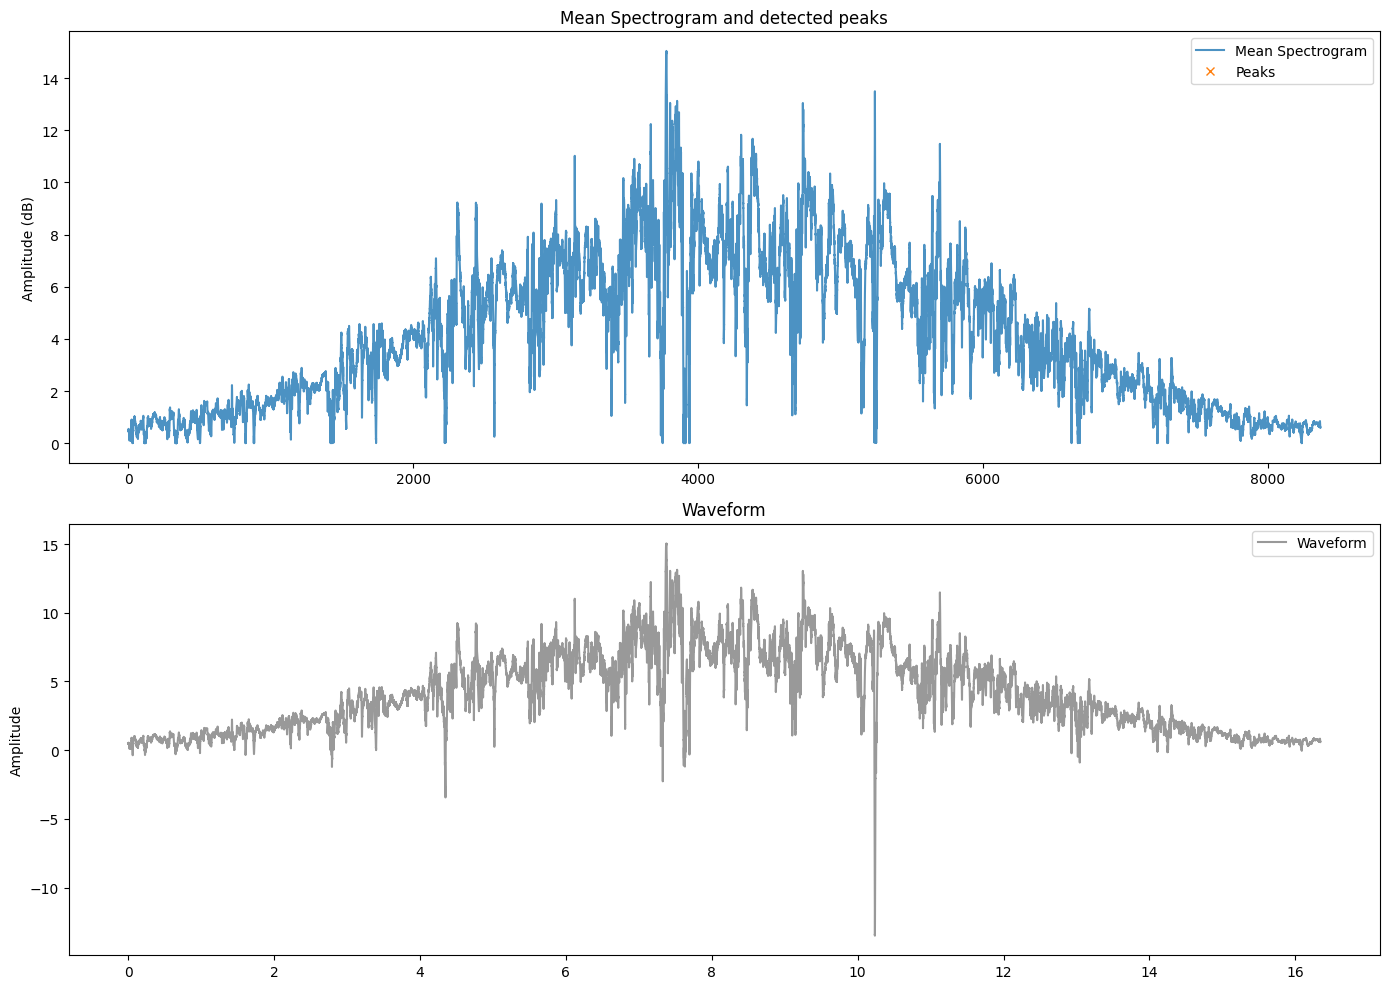

In [31]:
from IPython.lib.display import Audio
import matplotlib.pyplot as plt
import librosa
import numpy as np
from scipy.signal import find_peaks

def peak_detection(wav, n_fft=None, hop_length=None, height=None, distance=None, prominence=None, width=None, verbose=False):

    # 計算頻譜圖的列均值
    wav_form = np.abs(wav)
        
    # 使用 scipy.signal.find_peaks 檢測峰值
    peaks, properties = find_peaks(wav_form, height=height, distance=distance, prominence=prominence, width=width)
    
    if verbose:
        print(f'Found {len(peaks)} peaks')
    
    return peaks, wav_form

def plot_peak_detection(wav_file, sr, n_fft=None, hop_length=None, height=None, distance=10, prominence=1, width=None, verbose=False, save_only=False, output_dir='output'):

    wav, name = wav_file
    
    peaks, mean_spectrogram = peak_detection(wav, n_fft=n_fft, hop_length=hop_length, height=height, distance=distance, prominence=prominence, width=width, verbose=verbose)
    
    times = librosa.frames_to_time(np.arange(len(mean_spectrogram)), sr=sr, hop_length=hop_length)
    
    # 創建圖形
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    # 繪製頻譜圖
    ax1.set_title('Mean Spectrogram and detected peaks')
    ax1.plot(times, mean_spectrogram, alpha=0.8, label='Mean Spectrogram')
    ax1.plot(times[peaks], mean_spectrogram[peaks], "x", label='Peaks')
    ax1.vlines(times[peaks], min(mean_spectrogram), max(mean_spectrogram), color='r', alpha=0.8, linestyle='--')
    ax1.set_ylabel('Amplitude (dB)')
    ax1.legend(loc='upper right')
    
    # 繪製波形圖
    ax2.set_title('Waveform')
    ax2.plot(np.arange(len(wav)) / sr, wav, alpha=0.8, color='gray', label='Waveform')
    ax2.set_ylabel('Amplitude')
    ax2.legend(loc='upper right')
    
    # 顯示圖形
    plt.tight_layout()
    plt.show()
    
    # 顯示動畫和音頻
    display.display(Audio(wav, rate=target_sample_rate))

# 呼叫函式並傳遞參數
samples = target_sample_rate * 1
plot_peak_detection(loaded_files[0], sr=target_sample_rate, n_fft=2048, hop_length=512, width=samples, prominence=1, verbose=True)


In [ ]:
def segment_audio(data, sr=None, segment_length=2, hop_length=None, n_fft=None, height=None, distance=None, prominence=None, width=None, verbose=False):
    """
    Segment audio into clips based on onset detection.

    :param data: Audio time series
    :param segment_length: The desired length of each audio segment in seconds (default: 2)
    :param hop_length: Number of samples between successive frames (default: 512)
    :param n_fft: Length of the FFT window (default: 2048)
    :return: A tuple containing a list of audio segments and the sample rate (segments, sr)
    """
    # 載入音訊數據
    
    peaks, _ = peak_detection(data, n_fft=n_fft, hop_length=hop_length, height=height, distance=distance, prominence=prominence, width=width, verbose=verbose)
    
    # 將峰值位置轉換為時間戳
    peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length, n_fft=n_fft)
    
    # 切割音訊,每個片段長度固定為 segment_length 秒
    segments = []
    for peak_time in peak_times:
        # 根據 peak_time 和 segment_length 計算起始和結束時間
        start_time = max(0, peak_time - segment_length / 2)
        end_time = min(peak_time + segment_length / 2, len(data) / sr)
        
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segment = data[start_sample:end_sample]
        
        # 如果片段長度不足 segment_length 秒,則補零
        if len(segment) < segment_length * sr:
            padding_length = int(segment_length * sr) - len(segment)
            segment = np.pad(segment, (0, padding_length), mode='constant')
        
        segments.append(segment)
    
    return segments

# 在同一張圖上繪製所有片段的頻譜圖

In [ ]:
def plot_segments_of_audio(wav, sr, segment_length=2, n_fft=2048, hop_length=512, height=-64, distance=30, prominence=1, width=5, save_only=False, output_dir='output', verbose=False):
    audio, name = wav
    segments = segment_audio(audio, sr=sr, segment_length=segment_length, n_fft=n_fft, hop_length=hop_length, height=height, distance=distance, prominence=prominence, width=width, verbose=verbose)
    num_segments = len(segments)
    num_cols = 4
    num_rows = int(np.ceil(num_segments / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 13))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # 設置子圖之間的垂直間距
    fig.suptitle('Mel Spectrogram of Audio Segments', fontsize=16)  # 添加圖形總標題

    axes = np.atleast_2d(axes)  # 確保axes是2維數組

    for seg_idx in range(num_rows * num_cols):
        if seg_idx < num_segments:
            ax = axes[seg_idx // num_cols, seg_idx % num_cols]
            mel_spectrogram = convert_to_mel_spectrogram(segments[seg_idx], n_fft, hop_length, n_mels=128, sr=sr)
            img = librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length, ax=ax)
            ax.set_title(f'Segment {seg_idx + 1}')
        else:
            fig.delaxes(axes.flatten()[seg_idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 調整子圖布局以便顯示總標題
    plt.savefig(f'{output_dir}/mel_spectrogram_of_audio_segments_{name}.png')
    if not save_only:
        plt.show()
    else:
        plt.close()  # 關閉圖形以節省資源
    


In [ ]:
plot_segments_of_audio(highpass_audio[0], target_sample_rate, output_dir='segment_images', verbose=True)

In [ ]:
for audio in tqdm(highpass_audio, desc='Processing audio segments', unit='audio'):
    plot_segments_of_audio(audio, target_sample_rate, save_only=True,  output_dir='segment_images')